# Sistem Rekomendasi Buku

- **Nama:** Ferry Pebriansyah
- **Email:** ferryfeb10@gmail.com
- **ID Dicoding:** ferrypebriansyah

Dalam era digital, pengguna menghadapi tantangan information overload dalam memilih bacaan dari jutaan judul buku yang tersedia secara online [1]. Sistem rekomendasi buku berbasis Collaborative Filtering efektif membantu mengatasi masalah ini dengan mempelajari pola rating antar pengguna untuk memberikan rekomendasi yang relevan tanpa memerlukan informasi lengkap tentang buku [2][3].

Proyek ini membangun sistem rekomendasi berbasis Collaborative Filtering menggunakan embedding neural network dengan data rating eksplisit sebagai input utama, sejalan dengan pendekatan yang telah dilakukan di berbagai studi lokal [1][4]. Pendekatan ini penting karena banyak platform digital hanya memiliki data interaksi pengguna tanpa metadata lengkap [2].

Beberapa penelitian di Indonesia menunjukkan keberhasilan Collaborative Filtering dalam sistem rekomendasi buku, seperti implementasi algoritma K-Nearest Neighbors dengan evaluasi menggunakan MAE dan RMSE [1], serta penerapan pada perpustakaan daerah dengan fokus pada akurasi prediksi [2]. Penggunaan metode ini juga terbukti efektif untuk toko buku online dalam meningkatkan relevansi rekomendasi [3][4].

Dengan mengoptimalkan data interaksi pengguna, proyek ini diharapkan dapat memberikan rekomendasi yang personal dan akurat serta mendukung perkembangan literasi digital melalui teknologi personalisasi [1][4].

# Business Understanding

## Problem Statements

Rumusan masalah yang dijawab dalam proyek ini adalah:

1. Apa saja buku yang paling banyak mendapatkan rating dari pengguna, dan bagaimana karakteristiknya?

2. Bagaimana cara membangun sebuah sistem yang mampu memberikan rekomendasi buku yang relevan dan personal kepada pengguna, dengan hanya memanfaatkan riwayat rating eksplisit mereka?

## Goals

Berdasarkan problem statements di atas, tujuan yang berhasil dicapai pada proyek ini adalah:

1. Mengidentifikasi buku, penulis, dan karakteristik lainnya yang paling sering mendapatkan rating dari pengguna, berdasarkan analisis data rating eksplisit.

2. Membangun sebuah model sistem rekomendasi fungsional yang memberikan saran bacaan baru yang dipersonalisasi untuk setiap pengguna.






## Solution Approach

Untuk mencapai goals tersebut, pendekatan solusi yang telah diimplementasikan adalah:

1. Data Preparation dan Filtering:

- Melakukan pembersihan data pada kolom-kolom yang mengandung anomali (seperti Age dan Year-Of-Publication).

- Melakukan pemfilteran data secara krusial untuk hanya menggunakan baris dengan rating eksplisit (skor 1–10). Data dengan rating 0 (implisit) tidak digunakan dalam pemodelan agar hasil rekomendasi lebih akurat.

2. Implementasi Model Rekomendasi (Collaborative Filtering):

- Menggunakan pendekatan Collaborative Filtering berbasis embedding, di mana sistem mempelajari pola rating antar pengguna untuk mengidentifikasi kesamaan preferensi.

- Model kemudian merekomendasikan buku yang disukai oleh pengguna lain dengan selera serupa.

# Data Understanding

Tahap ini merupakan proses analisis data yang bertujuan untuk memperoleh pemahaman yang menyeluruh mengenai dataset sebelum melanjutkan ke tahap analisis lebih lanjut.

## 1. Mengimport Library


Pada bagian ini kita mengimport seluruh library yang diperlukan untuk menganalisis

In [1]:
!pip install kaggle

In [2]:
!pip install keras

In [3]:
import os
import shutil
import zipfile
import textwrap
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, classification_report

## Data Loading

Tahap untuk memuat dataset yang akan digunakan agar dataset lebih mudah dipahami. Pada project kali ini, menggunakan dataset yang berasal dari Kaggle. [Link Dataset](https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset?select=Users.csv)

In [4]:
#!/bin/bash
!curl -L -o book-recommendation.zip\
  "https://www.kaggle.com/api/v1/datasets/download/arashnic/book-recommendation-dataset"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 24.3M  100 24.3M    0     0  28.5M      0 --:--:-- --:--:-- --:--:-- 28.5M


In [5]:
#membuka zip menjadi folder
with zipfile.ZipFile("/content/book-recommendation.zip", "r") as zip_ref:
    zip_ref.extractall("book-recommendation")


In [6]:
books = pd.read_csv('/content/book-recommendation/Books.csv')
users = pd.read_csv('/content/book-recommendation/Users.csv')
ratings = pd.read_csv('/content/book-recommendation/Ratings.csv')

<ipython-input-6-87929e9b5d3b>:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv('/content/book-recommendation/Books.csv')


In [7]:
print('Jumlah data buku: ', len(books.ISBN.unique()))
print('Jumlah data user: ', len(users['User-ID'].unique()))
print('Jumlah data rating: ', len(ratings['User-ID']))
print('Jumlah data user yang memberi rating: ', len(ratings['User-ID'].unique()))

Jumlah data buku:  271360
Jumlah data user:  278858
Jumlah data rating:  1149780
Jumlah data user yang memberi rating:  105283


In [8]:
books.describe(include='all')

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
count,271360,271360,271358,271360,271358,271360,271360,271357
unique,271360,242135,102022,202,16807,271044,271044,271041
top,3462017942,Selected Poems,Agatha Christie,2002,Harlequin,http://images.amazon.com/images/P/042509474X.0...,http://images.amazon.com/images/P/042509474X.0...,http://images.amazon.com/images/P/006091985X.0...
freq,1,27,632,13903,7535,2,2,2


**Insight:**

Terdapat data judul buku sebesar 271.360 tetapi yang memiliki judul berbeda (unik) ada 102.022. Hal ini menunjukkan bahwa ada buku yang memiliki judul yang sama.

In [9]:
users.describe(include='all')

,User-ID,Location,Age
count,278858.00000,278858,168096.000000
unique,NaN,57339,NaN
top,NaN,"london, england, united kingdom",NaN
freq,NaN,2506,NaN
mean,139429.50000,NaN,34.751434
std,80499.51502,NaN,14.428097
min,1.00000,NaN,0.000000
25%,69715.25000,NaN,24.000000
50%,139429.50000,NaN,32.000000
75%,209143.75000,NaN,44.000000


**Insight:**
Terdapat umur yang tidak masuk akal pada kolom `Age` seperti umur dibawah 5 tahun dan diatas 90 tahun.

In [10]:
ratings.describe(include='all')

,User-ID,ISBN,Book-Rating
count,1.149780e+06,1149780,1.149780e+06
unique,NaN,340556,NaN
top,NaN,0971880107,NaN
freq,NaN,2502,NaN
mean,1.403864e+05,NaN,2.866950e+00
std,8.056228e+04,NaN,3.854184e+00
min,2.000000e+00,NaN,0.000000e+00
25%,7.034500e+04,NaN,0.000000e+00
50%,1.410100e+05,NaN,0.000000e+00
75%,2.110280e+05,NaN,7.000000e+00


**Insight:**

Berdasarkan informasi dataset pada sumbernya, kaggle, diketahui bahwa Penilaian buku (Book-Rating) memiliki dua jenis:

- **Eksplisit**:

Penilaian ini diberikan secara langsung oleh pengguna dalam bentuk angka pada skala 1 hingga 10. Semakin tinggi angka yang diberikan, semakin tinggi apresiasi atau kesukaan pengguna terhadap buku tersebut.


- **Implisit**:

Penilaian ini tidak diberikan secara langsung, melainkan ditandai dengan angka 0. Angka 0 ini mengindikasikan bahwa pengguna mungkin telah berinteraksi dengan buku tersebut (misalnya, melihat detailnya, menambahkannya ke daftar bacaan, atau melakukan tindakan lain), tetapi tidak memberikan penilaian eksplisit dalam skala 1-10.
Saya akan fokus membangun model collaborative filtering pada dara rating eksplisit, sehingga data rating implisit nantinya akan dihapus.

In [11]:
books.info()
users.info()
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)

**Insight:**
1. books = Terdapat missing value pada kolom `Book-Author`, `Publisher`, dan `Image-URL-L`.
2. users = Dapat dilihat bahwa terdapat banyak missing value pada kolom `Age`.
3. ratings = tidak terdapat missing value.

# Data Preparation

## Merge Table

In [12]:
# Menggabungkan ratings dengan users
df = pd.merge(ratings, users, on='User-ID', how='inner')

# Menggabungkan hasil di atas dengan books
df_merged = pd.merge(df, books, on='ISBN', how='inner')

In [13]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1031136 entries, 0 to 1031135
Data columns (total 12 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   User-ID              1031136 non-null  int64  
 1   ISBN                 1031136 non-null  object 
 2   Book-Rating          1031136 non-null  int64  
 3   Location             1031136 non-null  object 
 4   Age                  753301 non-null   float64
 5   Book-Title           1031136 non-null  object 
 6   Book-Author          1031134 non-null  object 
 7   Year-Of-Publication  1031136 non-null  object 
 8   Publisher            1031134 non-null  object 
 9   Image-URL-S          1031136 non-null  object 
 10  Image-URL-M          1031136 non-null  object 
 11  Image-URL-L          1031132 non-null  object 
dtypes: float64(1), int64(2), object(9)
memory usage: 94.4+ MB


**Insight**:
dataframe `merged_df`. gabungan antara dataframe `books`, `ratings`, dan `users`

| No. | Kolom                 | Tipe Data | Deskripsi                                                                    |
| --- | --------------------- | --------- | ---------------------------------------------------------------------------- |
| 1   | `User-ID`             | int64     | ID unik pengguna yang memberikan rating buku.                                |
| 2   | `ISBN`                | object    | ISBN (International Standard Book Number) sebagai ID unik untuk setiap buku. |
| 3   | `Book-Rating`         | int64     | Nilai rating yang diberikan pengguna terhadap buku (biasanya 0–10).          |
| 4   | `Location`            | object    | Lokasi pengguna dalam format .                       |
| 5   | `Age`                 | float64   | Usia pengguna (ada missing values).                                          |
| 6   | `Book-Title`          | object    | Judul buku yang diberi rating.                                               |
| 7   | `Book-Author`         | object    | Nama penulis buku (ada nilai kosong).                                        |
| 8   | `Year-Of-Publication` | object    | Tahun terbit buku. Awalnya bertipe object karena terdapat nilai non-numerik. |
| 9   | `Publisher`           | object    | Nama penerbit buku (ada nilai kosong).                                       |
| 10  | `Image-URL-S`         | object    | URL gambar ukuran kecil sampul buku.                                         |
| 11  | `Image-URL-M`         | object    | URL gambar ukuran sedang sampul buku.                                        |
| 12  | `Image-URL-L`         | object    | URL gambar ukuran besar sampul buku (ada nilai kosong).                      |


## Exploratory Data Analysis

### Distribusi Usia Pembaca

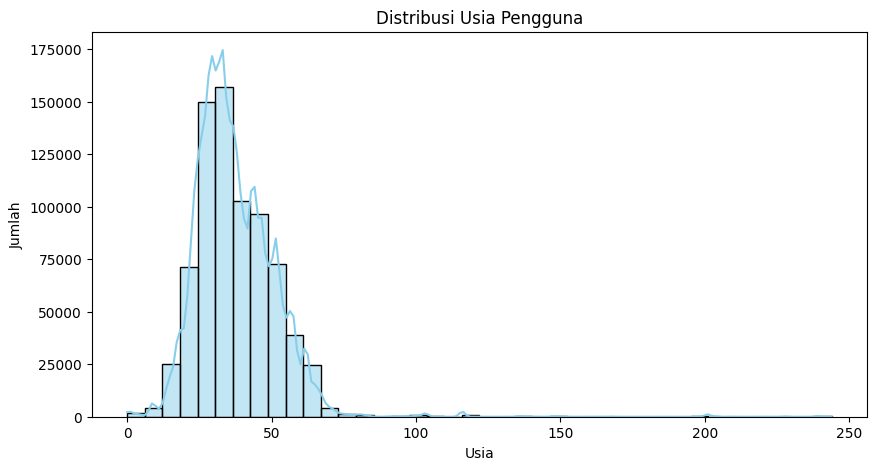

In [14]:
plt.figure(figsize=(10,5))
sns.histplot(df_merged['Age'].dropna(), bins=40, kde=True, color='skyblue')
plt.title('Distribusi Usia Pengguna')
plt.xlabel('Usia')
plt.ylabel('Jumlah')
plt.show()


**Insight:**

Berdasarkan histogram tersebut, dapat disimpulkan bahwa mayoritas pengguna dalam dataset ini adalah kalangan dewasa muda, dengan puncak distribusi usia terkonsentrasi secara signifikan antara 20 hingga 40 tahun. Grafik ini juga menunjukkan adanya right-skew (condong ke kanan), yang menandakan bahwa jumlah pengguna secara bertahap menurun seiring bertambahnya usia, meskipun masih ada basis pengguna yang cukup di usia paruh baya. Selain itu, terdapat indikasi kuat adanya data anomali atau outlier pada usia yang sangat rendah (mendekati 0) dan sangat tinggi (jauh di atas 100 tahun), yang mengindikasikan perlunya pembersihan data lebih lanjut sebelum analisis mendalam.

### Distribusi Buku yang Paling Banyak Dinilai

<ipython-input-15-24af2e207d4f>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_books.index, x=top_books.values, palette='magma')


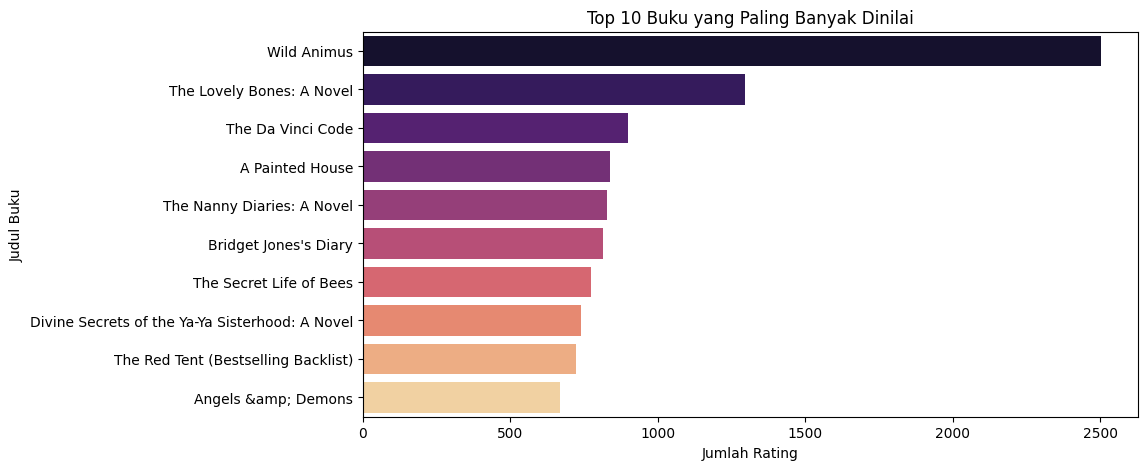

In [15]:
top_books = df_merged['Book-Title'].value_counts().head(10)

plt.figure(figsize=(10,5))
sns.barplot(y=top_books.index, x=top_books.values, palette='magma')
plt.title('Top 10 Buku yang Paling Banyak Dinilai')
plt.xlabel('Jumlah Rating')
plt.ylabel('Judul Buku')
plt.show()


**Insight:**

Berdasarkan grafik tersebut, terlihat jelas bahwa popularitas buku diukur dari jumlah rating yang diterima, bukan dari skor rata-ratanya. Buku "Wild Animus" merupakan outlier yang sangat dominan, menerima jumlah ulasan yang hampir dua kali lipat lebih banyak dibandingkan buku di peringkat kedua. Fenomena ini kemungkinan besar tidak murni mencerminkan kualitas buku, melainkan bisa jadi akibat dari kampanye pemasaran atau program bagi-bagi buku gratis yang masif pada masanya, sehingga menghasilkan interaksi yang sangat tinggi dalam dataset ini. Sementara itu, sisa dari daftar top 10 diisi oleh novel-novel fiksi populer dan bestseller yang sangat dikenal pada masanya seperti "The Lovely Bones" dan "The Da Vinci Code", yang mengindikasikan bahwa selera mayoritas pengguna dalam dataset ini cenderung ke arah fiksi komersial yang terkenal.

### Distribusi Penulis dengan Buku Paling Banyak Dirating

<ipython-input-16-1aee7f97799b>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_authors.index, x=top_authors.values, palette='cividis')


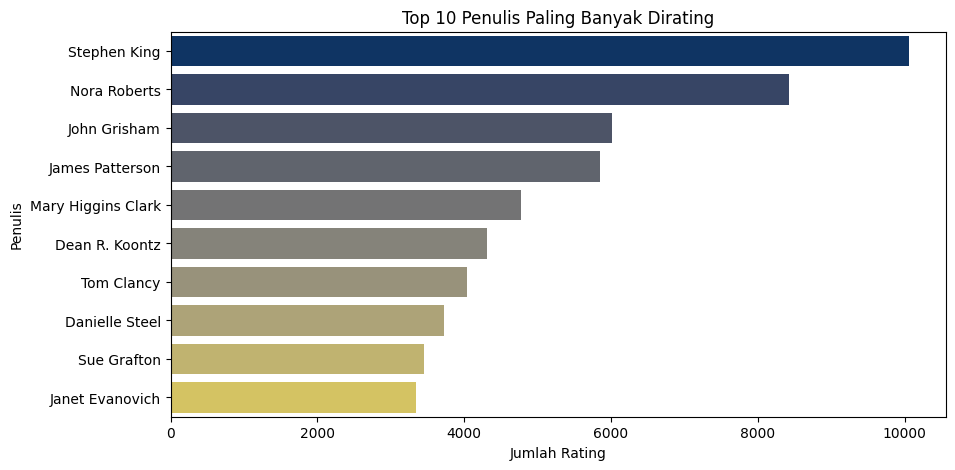

In [16]:
top_authors = df_merged['Book-Author'].value_counts().head(10)

plt.figure(figsize=(10,5))
sns.barplot(y=top_authors.index, x=top_authors.values, palette='cividis')
plt.title('Top 10 Penulis Paling Banyak Dirating')
plt.xlabel('Jumlah Rating')
plt.ylabel('Penulis')
plt.show()


**Insight:**

Grafik ini mengukuhkan dominasi penulis-penulis fiksi komersial ternama dalam menarik minat baca pengguna, dengan Stephen King secara meyakinkan menempati posisi teratas sebagai penulis yang karyanya paling banyak diulas. Daftar 10 besar ini didominasi secara kuat oleh para penulis 'powerhouse' yang sangat produktif dalam genre spesifik seperti thriller, misteri, dan romance, seperti Nora Roberts, John Grisham, dan James Patterson. Hal ini memberikan sinyal yang sangat jelas bahwa mayoritas pembaca dalam dataset ini memiliki preferensi yang kuat terhadap cerita-cerita yang penuh ketegangan (suspense) dan narasi romantis, di mana popularitas penulis dibangun secara kumulatif dari banyaknya karya yang mereka hasilkan, bukan hanya dari satu buku 'hit'.

### Distribusi Jumlah Rating per Buku

<ipython-input-17-dc49972af51a>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Book-Rating', data=explicit_ratings, palette='Set2')


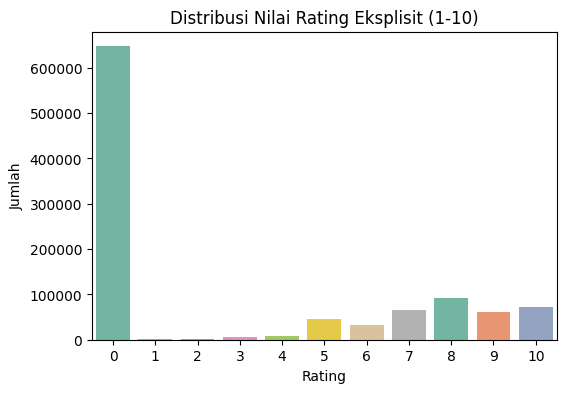

In [17]:
# Hanya rating eksplisit (1-10)
explicit_ratings = df_merged[df_merged['Book-Rating'] >= 0]

plt.figure(figsize=(6,4))
sns.countplot(x='Book-Rating', data=explicit_ratings, palette='Set2')
plt.title('Distribusi Nilai Rating Eksplisit (1-10)')
plt.xlabel('Rating')
plt.ylabel('Jumlah')
plt.show()


**Insight:**

Grafik distribusi rating ini menyoroti sebuah karakteristik fundamental dan paling penting dari dataset ini: mayoritas absolut interaksi (lebih dari 600.000) adalah rating '0'. Rating '0' ini bukanlah skor buruk, melainkan sebuah rating implisit, yang kemungkinan besar menandakan bahwa pengguna telah berinteraksi dengan buku tersebut (misalnya, ada di rak bukunya) tetapi tidak memberikan skor numerik secara eksplisit. Jika kita hanya berfokus pada rating eksplisit (skala 1-10), terlihat pola yang sangat berbeda, yaitu pengguna cenderung memberikan ulasan positif dengan jumlah rating yang sangat sedikit di skor rendah (1-4) dan mencapai puncaknya di skor 7 dan 8. Hal ini menunjukkan adanya bias ke arah rating positif untuk ulasan eksplisit dan menegaskan betapa krusialnya untuk memisahkan data implisit ('0') dan eksplisit (1-10) dalam analisis dan pemodelan selanjutnya.

## Data Quality Verification

In [18]:
# Menghitung jumlah nilai null untuk setiap kolom di df_merged
missing_values = df_merged.isnull().sum()

# Menampilkan hasilnya
print(missing_values)

User-ID                     0
ISBN                        0
Book-Rating                 0
Location                    0
Age                    277835
Book-Title                  0
Book-Author                 2
Year-Of-Publication         0
Publisher                   2
Image-URL-S                 0
Image-URL-M                 0
Image-URL-L                 4
dtype: int64


**Insight:**

Terdapat missing value pada kolom `Age` sebanyak  277835 atau kurang dari 50% sehingga akan saya hapus data tersebut.

In [19]:
# Menampilkan jumlah pengarang, jumlah penerbit, dan tahun terbit
print('Jumlah Pengarang: ', len(df_merged['Book-Author'].unique()))
print('Jumlah Penerbit: ', len(df_merged['Publisher'].unique()))
print('Tahun Terbit', df_merged['Year-Of-Publication'].unique())

Jumlah Pengarang:  101588
Jumlah Penerbit:  16730
Tahun Terbit [2002 '2001' 1996 '1999' 1998 2001 1994 1995 2003 1997 '1995' 1999 '1998'
 '2024' 1992 '1983' '2002' '1996' '2000' 0 '1989' '2003' '1991' 1993
 '1994' 1976 '1993' 1991 '0' 2000 1983 1990 1982 1988 1981 '1988' 1989
 1986 '1987' '1992' 1987 '1980' '1990' '1997' 2004 1984 '1982' '1985' 1985
 1979 '2004' '1984' 1974 '1979' 1977 1965 1972 '1978' '1986' '1981' 1962
 '1977' 1957 1958 1960 1963 1969 '1974' 1978 1970 '1972' 1980 '1975' 1959
 '1960' 1968 '1976' '1970' '1971' 1975 1973 '1950' '1969' '1962' 1971 1964
 1955 1953 1966 '1965' '1963' '1973' 1930 '1964' 1961 '1952' 1940 '1968'
 1954 '1967' '1911' 1952 1946 1941 1920 1967 1956 1942 1951 1948 '1959'
 1950 2005 1943 1937 1923 1945 1947 1936 1925 '1966' '1958' 1927 2030 2011
 2020 1939 1926 1938 '1961' 1911 1904 1949 1932 1929 '1953' '1955' '1944'
 '1920' '1956' '1957' '1942' '1933' '1922' '1897' '1954' '1941' '1949'
 '1939' 2050 '1947' 1902 1924 1921 1900 '1945' '2005' 2038 20

**insight:**

Dapat dilihat bahwa pada data tahun masih belum seragam, ada yang menggunakan tanda petik dan ada yang tidak. Selain itu, terdapat data yang salah, yaitu *DK Publishing Inc* dan *Gallimard* yang seharusnya berada pada kolom Publisher (penerbit). Data ini akan dihapus pada bagian Data Preparation.

In [20]:
# Membuat daftar nilai anomali yang ingin dicari
outliner_values = ['DK Publishing Inc', 'Gallimard']

# Mencari semua baris di mana 'Year-Of-Publication' adalah salah satu dari nilai di dalam daftar
books.loc[books['Year-Of-Publication'].isin(outliner_values)]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,NaN
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-M...",2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,NaN
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,NaN


In [21]:
# Menghitung berapa banyak baris yang merupakan duplikat penuh dari baris sebelumnya
jumlah_duplikat_penuh = df_merged.duplicated().sum()

print(f"Ditemukan {jumlah_duplikat_penuh} jumlah duplikasi data")

Ditemukan 0 jumlah duplikasi data


In [22]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1031136 entries, 0 to 1031135
Data columns (total 12 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   User-ID              1031136 non-null  int64  
 1   ISBN                 1031136 non-null  object 
 2   Book-Rating          1031136 non-null  int64  
 3   Location             1031136 non-null  object 
 4   Age                  753301 non-null   float64
 5   Book-Title           1031136 non-null  object 
 6   Book-Author          1031134 non-null  object 
 7   Year-Of-Publication  1031136 non-null  object 
 8   Publisher            1031134 non-null  object 
 9   Image-URL-S          1031136 non-null  object 
 10  Image-URL-M          1031136 non-null  object 
 11  Image-URL-L          1031132 non-null  object 
dtypes: float64(1), int64(2), object(9)
memory usage: 94.4+ MB


# Data Preparation

## Data Cleaning

In [23]:
# Menghapus nilai yang tetukar
indeks_salah = df_merged[df_merged['Year-Of-Publication'].isin(['DK Publishing Inc', 'Gallimard'])].index

# Hapus baris berdasarkan indeksnya
df_merged.drop(indeks_salah, inplace=True)

In [24]:
# Menghapus kolom Image URL karena tidak digunakan pada analisis
df_merged.drop(['Age','Location','Image-URL-S', 'Image-URL-M', 'Image-URL-L'], axis=1, inplace=True)

In [25]:
# Mengisi nilai yang kosong pada kolom 'Book-Author' dan 'Publisher' dengan 'other'
df_merged['Book-Author'] = df_merged['Book-Author'].fillna('other')
df_merged['Publisher'] = df_merged['Publisher'].fillna('other')

In [26]:
# Cek apakah data telah berhasil diubah menjadi 'other'
df_merged.loc[df_merged['Book-Author'] == 'other', :]

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher
244331,63714,0751352497,10,A+ Quiz Masters:01 Earth,other,1999,Dorling Kindersley
369234,98647,9627982032,8,The Credit Suisse Guide to Managing Your Perso...,other,1995,Edinburgh Financial Publishing


In [27]:
# Pastikan kolom bertipe string dan isi NaN diganti string kosong dulu agar tidak error saat isdigit()
df_merged['Year-Of-Publication'] = df_merged['Year-Of-Publication'].astype(str).fillna('')

# Gunakan .str.isdigit() untuk filter baris dengan tahun valid
df_merged = df_merged[df_merged['Year-Of-Publication'].str.isdigit()]

# Ubah ke integer
df_merged['Year-Of-Publication'] = df_merged['Year-Of-Publication'].astype(int)

# Buang baris dengan tahun tidak masuk akal (misalnya < 1900 atau > 2025)
df_merged = df_merged[(df_merged['Year-Of-Publication'] >= 1900) &
                      (df_merged['Year-Of-Publication'] <= 2025)]


In [28]:
# Ambil hanya data rating eksplisit
ratings_explicit = df_merged[df_merged['Book-Rating'] != 0]

print(f"Jumlah baris sebelum drop implisit: {len(df_merged)}")
print(f"Jumlah baris setelah drop implisit: {len(ratings_explicit)}")

df_merged = ratings_explicit

Jumlah baris sebelum drop implisit: 1017066
Jumlah baris setelah drop implisit: 378031


In [29]:
print("Tahun unik setelah dibersihkan:", sorted(df_merged['Year-Of-Publication'].unique()))


Tahun unik setelah dibersihkan: [np.int64(1900), np.int64(1901), np.int64(1902), np.int64(1904), np.int64(1906), np.int64(1908), np.int64(1911), np.int64(1920), np.int64(1923), np.int64(1924), np.int64(1925), np.int64(1926), np.int64(1927), np.int64(1928), np.int64(1929), np.int64(1930), np.int64(1931), np.int64(1932), np.int64(1933), np.int64(1934), np.int64(1935), np.int64(1936), np.int64(1937), np.int64(1938), np.int64(1939), np.int64(1940), np.int64(1941), np.int64(1942), np.int64(1943), np.int64(1944), np.int64(1945), np.int64(1946), np.int64(1947), np.int64(1948), np.int64(1949), np.int64(1950), np.int64(1951), np.int64(1952), np.int64(1953), np.int64(1954), np.int64(1955), np.int64(1956), np.int64(1957), np.int64(1958), np.int64(1959), np.int64(1960), np.int64(1961), np.int64(1962), np.int64(1963), np.int64(1964), np.int64(1965), np.int64(1966), np.int64(1967), np.int64(1968), np.int64(1969), np.int64(1970), np.int64(1971), np.int64(1972), np.int64(1973), np.int64(1974), np.int6

In [30]:
df_merged.duplicated().sum()

np.int64(0)

In [31]:
df_merged.duplicated(subset=['User-ID', 'ISBN']).sum()

np.int64(0)

In [32]:
df_merged = df_merged.reset_index(drop=True)
print(df_merged.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378031 entries, 0 to 378030
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   User-ID              378031 non-null  int64 
 1   ISBN                 378031 non-null  object
 2   Book-Rating          378031 non-null  int64 
 3   Book-Title           378031 non-null  object
 4   Book-Author          378031 non-null  object
 5   Year-Of-Publication  378031 non-null  int64 
 6   Publisher            378031 non-null  object
dtypes: int64(3), object(4)
memory usage: 20.2+ MB
None


In [33]:
df_merged.describe(include='all')

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher
count,378031.000000,378031,378031.000000,378031,378031,378031.000000,378031
unique,NaN,147103,NaN,133367,61222,NaN,11271
top,NaN,0316666343,NaN,The Lovely Bones: A Novel,Stephen King,NaN,Ballantine Books
freq,NaN,707,NaN,707,4602,NaN,12771
mean,136103.696461,NaN,7.627300,NaN,NaN,1995.705582,NaN
std,80457.063780,NaN,1.841682,NaN,NaN,7.293339,NaN
min,8.000000,NaN,1.000000,NaN,NaN,1900.000000,NaN
25%,67775.000000,NaN,7.000000,NaN,NaN,1993.000000,NaN
50%,133950.000000,NaN,8.000000,NaN,NaN,1998.000000,NaN
75%,206249.000000,NaN,9.000000,NaN,NaN,2001.000000,NaN


In [34]:
df_merged.isnull().sum()


,0
User-ID,0
ISBN,0
Book-Rating,0
Book-Title,0
Book-Author,0
Year-Of-Publication,0
Publisher,0


In [35]:
# Membuat dictionary untuk data 'book_id', 'title', 'author', dan 'publisher'
book_new = books.rename(columns={
    'ISBN': 'id',
    'Book-Title': 'book_title',
    'Book-Author': 'book_author',
    'Publisher': 'publisher'
})[['id', 'book_title', 'book_author', 'publisher']]


# Modeling and Result

In [36]:
df_model = df_merged[['User-ID', 'ISBN', 'Book-Rating']].copy()
df_model = df_model.rename(columns={'User-ID': 'user_id', 'ISBN': 'isbn', 'Book-Rating': 'rating'})


In [37]:
# Mengubah user_id menjadi list tanpa nilai yang sama
user_ids = df_model['user_id'].unique().tolist()
print('list user_id: ', user_ids)

# Melakukan encoding user_id
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
print('encoded user_id : ', user_to_user_encoded)

# Melakukan proses encoding angka ke user_id
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
print('encoded angka ke user_id: ', user_encoded_to_user)


list user_id:  [276726, 276729, 276744, 276747, 276748, 276751, 276754, 276755, 276762, 276772, 276774, 276786, 276788, 276796, 276798, 276800, 276804, 276808, 276811, 276813, 276814, 276822, 276828, 276830, 276832, 276835, 276837, 276847, 276850, 276853, 276854, 276859, 276861, 276862, 276866, 276872, 276875, 276878, 276887, 276896, 276904, 276905, 276911, 276915, 276916, 276925, 276927, 276928, 276929, 276936, 276939, 276949, 276953, 276954, 276957, 276964, 276984, 276986, 276988, 276994, 276998, 277002, 277009, 277012, 277018, 277023, 277028, 277031, 277032, 277036, 277042, 277048, 277051, 277053, 277056, 277065, 277072, 277079, 277085, 277087, 277094, 277096, 277107, 277109, 277116, 277124, 277128, 277134, 277135, 277139, 277143, 277157, 277165, 277168, 277170, 277171, 277179, 277186, 277187, 277188, 277189, 277195, 277196, 277197, 277203, 277205, 277212, 277220, 277228, 277229, 277230, 277235, 277237, 277240, 277242, 277243, 277244, 277246, 277253, 277256, 277257, 277261, 277262, 

In [38]:
# Mengubah isbn menjadi list tanpa nilai yang sama
book_ids = df_model['isbn'].unique().tolist()

# Melakukan proses encoding isbn
book_to_book_encoded = {x: i for i, x in enumerate(book_ids)}

# Melakukan proses encoding angka ke isbn
book_encoded_to_book = {i: x for i, x in enumerate(book_ids)}

In [39]:
df_model['user'] = df_model['user_id'].map(user_to_user_encoded)
df_model['book'] = df_model['isbn'].map(book_to_book_encoded)


In [40]:
# Mendapatkan jumlah user
num_users = len(user_to_user_encoded)
print(num_users)

# Mendapatkan jumlah buku
num_books = len(book_encoded_to_book)
print(num_books)

# Mengubah rating menjadi nilai float
df_model['rating'] = df_model['rating'].values.astype(np.float32)

# Nilai minimum rating
min_rating = df_model['rating'].min()

# Nilai maksimal rating
max_rating = df_model['rating'].max()

print('Number of User: {}, Number of Book: {}, Min Rating: {}, Max Rating: {}'.format(
    num_users, num_books, min_rating, max_rating
))

67073
147103
Number of User: 67073, Number of Book: 147103, Min Rating: 1.0, Max Rating: 10.0


## Data Splitting

In [41]:
# Mengacak dataset
df_model = df_model.sample(frac=1, random_state=42)
df_model

,user_id,isbn,rating,user,book
217735,153682,0805019367,5.0,37642,32447
28490,16795,0399526544,10.0,4369,21164
45192,29000,0553572997,8.0,7355,669
145040,98904,0449221490,7.0,24407,13892
270164,193378,1551666669,6.0,46966,98084
...,...,...,...,...,...
259178,185233,0684853515,5.0,45080,4724
365838,266580,0552997595,9.0,64645,144205
131932,93800,0440234743,6.0,23145,4786
146867,100644,0312871880,4.0,24807,73847


In [42]:
# Membuat variabel x untuk mencocokkan data user dan book menjadi satu value (pakai df_model yang sudah shuffle)
x = df_model[['user', 'book']].values

# Membuat variabel y dengan rating yang sudah dinormalisasi
y = df_model['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * df_model.shape[0])
x_train, x_val = x[:train_indices], x[train_indices:]
y_train, y_val = y[:train_indices], y[train_indices:]

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)


(302424, 2) (302424,)
(75607, 2) (75607,)


## Modelling

In [43]:
class RecommenderNet(tf.keras.Model):

  # Insialisasi fungsi
  def __init__(self, num_users, num_book, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_book = num_book
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding( # layer embedding user
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1) # layer embedding user bias
    self.book_embedding = layers.Embedding( # layer embeddings book
        num_book,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.book_bias = layers.Embedding(num_book, 1) # layer embedding book bias

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # memanggil layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # memanggil layer embedding 2
    book_vector = self.book_embedding(inputs[:, 1]) # memanggil layer embedding 3
    book_bias = self.book_bias(inputs[:, 1]) # memanggil layer embedding 4

    dot_user_book = tf.tensordot(user_vector, book_vector, 2)

    x = dot_user_book + user_bias + book_bias

    return tf.nn.sigmoid(x)

In [44]:
model = RecommenderNet(num_users, num_books, 20)  # inisialisasi model

model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)


In [45]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(
    monitor='val_root_mean_squared_error',  # metric yang kamu pakai di compile
    patience=5,                            # berapa epoch tanpa perbaikan sebelum stop
    restore_best_weights=True              # kembalikan bobot terbaik setelah training selesai
)

In [46]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=32,
    epochs=100,
    validation_data=(x_val, y_val),
    callbacks=[early_stop]
)


Epoch 1/100
9451/9451 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - loss: 0.0772 - root_mean_squared_error: 0.2757 - val_loss: 0.0414 - val_root_mean_squared_error: 0.1976
Epoch 2/100
9451/9451 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - loss: 0.0380 - root_mean_squared_error: 0.1893 - val_loss: 0.0397 - val_root_mean_squared_error: 0.1933
Epoch 3/100
9451/9451 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - loss: 0.0345 - root_mean_squared_error: 0.1796 - val_loss: 0.0385 - val_root_mean_squared_error: 0.1903
Epoch 4/100
9451/9451 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - loss: 0.0320 - root_mean_squared_error: 0.1728 - val_loss: 0.0380 - val_root_mean_squared_error: 0.1893
Epoch 5/100
9451/9451 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - loss: 0.0301 - root_mean_squared_error: 0.1676 - val_loss: 0.0374 - val_root_mean_squared_error: 0.1880
Epoch 6/100
9451/9451 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - loss: 0.0284 - root_mean_squared_error: 0.1628 - val_loss: 0.0373 - val_root_mean_squared_error: 0.1881
Epoch 7/100
9451/9451 ━━━━━━

**Insight:**

1. Loss dan RMSE pada training menurun dengan konsisten

- Pada epoch 1, loss training 0.0772 dengan RMSE 0.2757.

- Pada epoch 12, loss training turun menjadi 0.0223 dengan RMSE 0.1449.
Ini menunjukkan model belajar dan beradaptasi dengan baik pada data training.

2. Val_loss dan val_RMSE cenderung stagnan atau sedikit membaik

- Pada epoch 1, val_loss 0.0414 dan val_RMSE 0.1976.

- Pada epoch 12, val_loss 0.0370 dan val_RMSE 0.1889.
Penurunan validasi error tidak sebanyak pada training, cenderung stagnan di sekitar nilai 0.0370 dan RMSE sekitar 0.188-0.189.

3. Durasi tiap epoch cukup stabil antara 30-40 detik

- Tidak ada tanda adanya bottleneck proses training.

# Evaluation

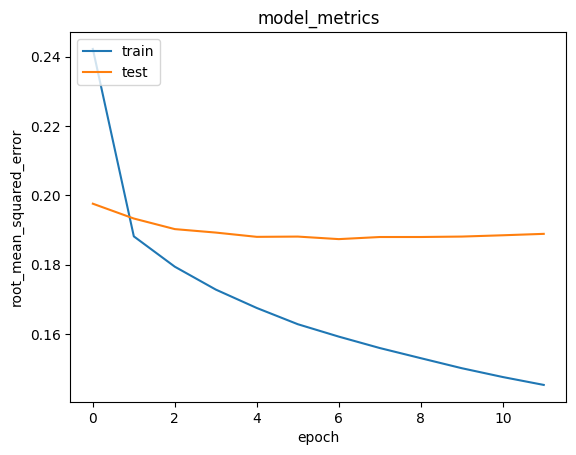

In [47]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


**Insight;**

Dari grafik RMSE terlihat bahwa training error terus menurun, menunjukkan model semakin baik mempelajari data training. Namun, validation error awalnya turun lalu stabil dan sedikit naik, menandakan model sudah mencapai batas generalisasi pada data validasi. Terdapat gap antara training dan validation error yang menunjukkan model mulai overfitting. Disarankan untuk menggunakan early stopping, teknik regularisasi seperti dropout atau L2, serta melakukan tuning hyperparameter dan menambah data jika memungkinkan untuk mengurangi overfitting dan meningkatkan performa.

In [48]:
def precision_recall_at_k(model, x_val, y_val, k=10):
    # Asumsikan x_val bentuknya [user_id, book_id], dan y_val adalah rating sebenarnya
    hit = 0
    total_recommended = 0
    total_relevant = 0

    user_ids = np.unique(x_val[:, 0])

    for user_id in user_ids:
        # Ambil semua data val user ini
        idx = x_val[:, 0] == user_id
        books = x_val[idx, 1]
        ratings_true = y_val[idx]

        if len(books) < k:
            continue

        # Prediksi untuk semua buku milik user ini
        input_pairs = np.hstack((np.full((len(books), 1), user_id), books.reshape(-1, 1)))
        preds = model.predict(input_pairs).flatten()

        # Ambil Top-K
        top_k_idx = preds.argsort()[-k:][::-1]
        recommended_ratings = ratings_true[top_k_idx]

        # Asumsikan rating > 0.5 adalah relevan
        hit += np.sum(recommended_ratings >= 0.5)
        total_recommended += k
        total_relevant += np.sum(ratings_true >= 0.5)

    precision = hit / total_recommended
    recall = hit / total_relevant
    return precision, recall

precision, recall = precision_recall_at_k(model, x_val, y_val, k=10)
print(f"Precision@10: {precision:.4f}")
print(f"Recall@10: {recall:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

**Insight:**
Precision@10 sebesar 87.88% menunjukkan bahwa dari setiap 10 rekomendasi yang diberikan, sekitar 8 hingga 9 item benar-benar relevan dengan preferensi user. Ini menandakan model sangat akurat dalam memilih rekomendasi yang tepat.

Sementara itu, Recall@10 sebesar 41.68% berarti dari semua item relevan yang ada untuk setiap user, sekitar 41% berhasil masuk dalam 10 rekomendasi teratas. Angka ini cukup baik dan wajar mengingat rekomendasi hanya dibatasi pada Top-10, sedangkan total item relevan bisa jauh lebih banyak.

## Metrik Evaluasi

### Root Mean Squared Error (RMSE)

RMSE mengukur seberapa besar perbedaan (*error*) antara rating prediksi dan rating aktual dari pengguna. Metrik ini cocok digunakan pada sistem rekomendasi berbasis rating eksplisit, seperti dalam proyek ini.

**Rumus:**

$$
\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (\hat{r}_i - r_i)^2}
$$

Dimana:  
- $\hat{r}_i$ : rating prediksi dari model  
- $r_i$ : rating aktual dari pengguna  
- $n$ : jumlah data  


**Cara kerja:**  
Semakin kecil nilai RMSE, semakin kecil selisih antara rating prediksi dan aktual → berarti model lebih akurat.


### Precision@K dan Recall@K

Metrik ini digunakan untuk mengevaluasi performa sistem rekomendasi dalam hal *relevansi* terhadap item (buku) yang direkomendasikan.

**Precision@K**

Mengukur proporsi item yang **relevan** dari total \(K\) item yang direkomendasikan.

$$
\text{Precision@K} = \frac{\text{Jumlah item relevan di top-}K}{K}
$$

**Recall@K**

Mengukur proporsi item relevan yang berhasil direkomendasikan dari seluruh item relevan yang tersedia.

$$
\text{Recall@K} = \frac{\text{Jumlah item relevan di top-}K}{\text{Total item relevan}}
$$

**Hasil:**

- Precision@10 = 0.8788: berarti 87.88% dari 10 buku yang direkomendasikan memang relevan.

- Recall@10 = 0.4168: berarti model berhasil menemukan sekitar 41.68% dari semua buku relevan untuk user.

## Interpretasi dan Insight dari Evaluasi

1. RMSE Insight:
- Jika grafik RMSE validasi menurun dan stabil, itu menunjukkan model belajar dengan baik.

- Gap besar antara RMSE training dan validasi → bisa jadi overfitting.

2. Precision & Recall Insight:
- Tinggi precision berarti rekomendasi yang diberikan relevan.

- Recall moderat menunjukkan model bisa ditingkatkan lagi untuk menemukan lebih banyak item relevan.

- Bisa jadi model terlalu konservatif (memilih item yang sudah populer), sehingga tidak mengeksplor banyak opsi relevan lainnya.

# Menjawab Problems

## 1. Mengidentifikasi buku, penulis, dan karakteristik lainnya yang paling sering mendapatkan rating dari pengguna, berdasarkan analisis data rating eksplisit.



<ipython-input-52-305ec5f30c1e>:15: UserWarning: Glyph 128218 (\N{BOOKS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128218 (\N{BOOKS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


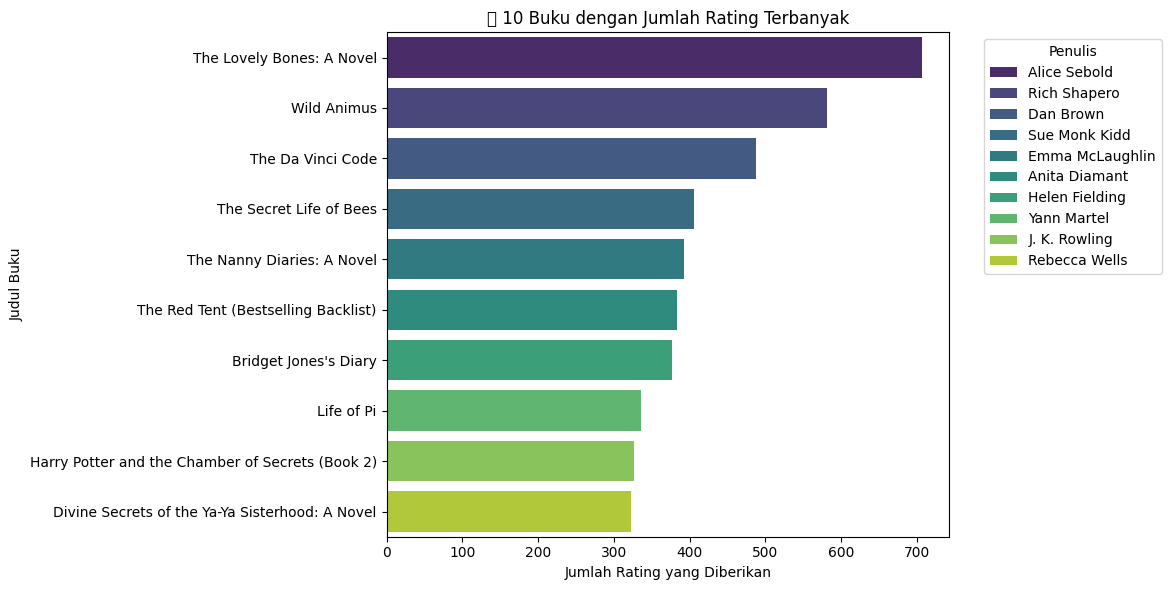

In [52]:
# Hitung jumlah rating per judul buku
top_rated_books = df_merged.groupby(['Book-Title', 'Book-Author']).size().reset_index(name='Jumlah_Rating')

# Ambil N teratas (misal: 10 buku paling banyak diberi rating)
top_n = top_rated_books.sort_values(by='Jumlah_Rating', ascending=False).head(10)

# Visualisasi
plt.figure(figsize=(12, 6))
sns.barplot(data=top_n, x='Jumlah_Rating', y='Book-Title', hue='Book-Author', dodge=False, palette='viridis')

plt.xlabel("Jumlah Rating yang Diberikan")
plt.ylabel("Judul Buku")
plt.title("📚 10 Buku dengan Jumlah Rating Terbanyak")
plt.legend(title='Penulis', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## 2. Membangun sebuah model sistem rekomendasi fungsional yang memberikan saran bacaan baru yang dipersonalisasi untuk setiap pengguna.

In [49]:
import numpy as np
import pandas as pd

# Ambil satu user secara random dari df_model
user_id = df_model['user_id'].sample(1).iloc[0]

# Ambil buku yang sudah dirating user ini
book_rated_by_user = df_model[df_model['user_id'] == user_id]

# Buku yang belum dirating user
all_books = set(df_model['isbn'].unique())
rated_books = set(book_rated_by_user['isbn'].unique())
books_not_rated = list(all_books - rated_books)

# Filter buku yang ada di encoding
books_not_rated = [b for b in books_not_rated if b in book_to_book_encoded]

# Buat array input model: pasangan [user_encoded, book_encoded]
user_encoded = user_to_user_encoded[user_id]
book_encoded_list = [book_to_book_encoded[b] for b in books_not_rated]

user_array = np.array([user_encoded] * len(book_encoded_list))
book_array = np.array(book_encoded_list)
user_book_array = np.column_stack((user_array, book_array))

# Prediksi rating untuk buku yang belum dirating
predicted_ratings = model.predict(user_book_array).flatten()

# Ambil top 10 buku dengan rating tertinggi
top_k = 10
top_k_indices = predicted_ratings.argsort()[-top_k:][::-1]
recommended_books_encoded = [book_encoded_list[i] for i in top_k_indices]

# Mapping ke id buku asli
recommended_books = [book_encoded_to_book[b] for b in recommended_books_encoded]

print(f"Rekomendasi untuk user_id: {user_id}\n")

# Ambil top 5 buku yang sudah dirating user, urutkan berdasarkan rating tertinggi
top_rated_books = book_rated_by_user.sort_values('rating', ascending=False).head(5)

# Hitung rata-rata rating per buku dari data rating yang ada
avg_rating_per_book = df_model.groupby('isbn')['rating'].mean().reset_index()
avg_rating_per_book.rename(columns={'rating': 'Rata-rata Rating'}, inplace=True)

# Buat dataframe buku sudah dirating user dengan judul asli, author, publisher
rated_books_list = []
for _, row in top_rated_books.iterrows():
    book_info = book_new[book_new['id'] == row['isbn']]
    if not book_info.empty:
        title = book_info.iloc[0]['book_title']
        author = book_info.iloc[0]['book_author']
        publisher = book_info.iloc[0]['publisher']
    else:
        title = author = publisher = "Tidak Diketahui"
    rated_books_list.append({
        'ISBN': row['isbn'],
        'Judul': title,
        'Penulis': author,
        'Penerbit': publisher,
        'Rating User': row['rating']
    })

df_rated = pd.DataFrame(rated_books_list)

# Buat dataframe rekomendasi buku baru dengan judul, author, publisher dan rata-rata rating
recommended_books_list = []
for isbn in recommended_books:
    book_info = book_new[book_new['id'] == isbn]
    if not book_info.empty:
        title = book_info.iloc[0]['book_title']
        author = book_info.iloc[0]['book_author']
        publisher = book_info.iloc[0]['publisher']
    else:
        title = author = publisher = "Tidak Diketahui"

    avg_rating_row = avg_rating_per_book[avg_rating_per_book['isbn'] == isbn]
    avg_rating = round(avg_rating_row['Rata-rata Rating'].values[0], 2) if not avg_rating_row.empty else "N/A"

    recommended_books_list.append({
        'ISBN': isbn,
        'Judul': title,
        'Penulis': author,
        'Penerbit': publisher,
        'Rata-rata Rating': avg_rating
    })

df_recommended = pd.DataFrame(recommended_books_list)

# Tampilkan hasil
print("Buku yang sudah dirating user (top 5):")
print(df_rated.to_string(index=False))

print("\nRekomendasi buku cocok untuk dibaca selanjutnya:")
print(df_recommended.to_string(index=False))


4597/4597 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
Rekomendasi untuk user_id: 65946

Buku yang sudah dirating user (top 5):
      ISBN                                                Judul         Penulis                Penerbit  Rating User
0394551419                                        A Perfect Spy   John Le Carre           Smithmark Pub          8.0
0684850273                       The FALL OF A SPARROW: A NOVEL Robert Hellenga                Scribner          7.0
0385334036                                     The Smoke Jumper  Nicholas Evans         Delacorte Press          7.0
0440221099                           Talk Before Sleep: A Novel  Elizabeth Berg                  Island          7.0
0743431014 Songs of the Humpback Whale : A Novel in Five Voices    Jodi Picoult Washington Square Press          6.0

Rekomendasi buku cocok untuk dibaca selanjutnya:
      ISBN                                                     Judul          Penulis                      Penerbit  Rata-rata Ratin

Daftar Referensi:

[1] Saputra, V. S., Ridwan, A., & Pratama, T. G. (2025).
"Rancang Bangun Sistem Rekomendasi Buku Berbasis Item-Based Collaborative Filtering Menggunakan Algoritma K-Nearest Neighbors."
Jurnal JUST IT, Vol. 15, No. 2, pp. 325–331, Universitas Muhammadiyah Kudus.
[Penelitian ini membahas sistem rekomendasi buku dengan collaborative filtering berbasis K-NN dan evaluasi menggunakan MAE serta RMSE].

[2] Fathoni, M. (2023).
"Sistem Rekomendasi Buku di Perpustakaan Daerah Jepara Menggunakan Metode Item-Based Collaborative Filtering."
Jurnal Biner, Universitas Sains Al-Qur'an.
[Studi kasus penerapan collaborative filtering di perpustakaan daerah dengan evaluasi MAE].

[3] ‘Uyun, S., Fahrurozzi, I., & Mulyanto, A. (2020).
"Item Collaborative Filtering untuk Rekomendasi Pembelian Buku secara Online."
Jurnal Sistem Informasi, Universitas Ahmad Dahlan.
[Pengembangan sistem rekomendasi pada toko buku online dengan collaborative filtering].

[4] Tim Jurnal Ilmu Komputer dan Sistem Informasi, Universitas Tarumanagara (2024).
"Implementasi Metode Collaborative Filtering Based Untuk Sistem Rekomendasi Buku."
JIKSI, Universitas Tarumanagara.
[Analisis collaborative filtering dalam sistem rekomendasi buku dan evaluasi akurasi menggunakan MAE].

